In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization

In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=1d4137fa2104de2fec4a9af2937be337bde41962a8746cb98447e91066c439ec
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
eurusd = pd.read_csv('/kaggle/input/forex/EURUSD-60-DS.csv')

# دیتافریم‌های جدید
audusd = pd.read_csv('/kaggle/input/forex/AUDUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
gbpusd = pd.read_csv('/kaggle/input/forex/GBPUSD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
usdcad = pd.read_csv('/kaggle/input/forex/USDCAD-60-DS.csv', header=None, names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

In [4]:
for df in [eurusd, audusd, gbpusd, usdcad]:
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')

In [5]:
# تنظیم Date به‌عنوان ایندکس
eurusd.set_index('Date', inplace=True)
audusd.set_index('Date', inplace=True)
gbpusd.set_index('Date', inplace=True)
usdcad.set_index('Date', inplace=True)

In [6]:
eurusd = eurusd.add_prefix('EURUSD_')
audusd = audusd.add_prefix('AUDUSD_')
gbpusd = gbpusd.add_prefix('GBPUSD_')
usdcad = usdcad.add_prefix('USDCAD_')
df = eurusd.join([audusd, gbpusd, usdcad], how='inner')

In [7]:
df.columns

Index(['EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'EURUSD_Close',
       'EURUSD_Volume', 'AUDUSD_Open', 'AUDUSD_High', 'AUDUSD_Low',
       'AUDUSD_Close', 'AUDUSD_Volume', 'GBPUSD_Open', 'GBPUSD_High',
       'GBPUSD_Low', 'GBPUSD_Close', 'GBPUSD_Volume', 'USDCAD_Open',
       'USDCAD_High', 'USDCAD_Low', 'USDCAD_Close', 'USDCAD_Volume'],
      dtype='object')

In [8]:
import pandas as pd
import pandas_ta as ta

# محاسبه اندیکاتورها بر اساس EUR/USD
df['rsi_14_EURUSD'] = ta.rsi(df['EURUSD_Close'], length=14)
df['atr_14_EURUSD'] = ta.atr(df['EURUSD_High'], df['EURUSD_Low'], df['EURUSD_Close'], length=14)
df['obv_EURUSD'] = ta.obv(df['EURUSD_Close'], df['EURUSD_Volume'])

# محاسبه MACD
macd = ta.macd(df['EURUSD_Close'], fast=12, slow=26, signal=9)
macd.columns = [col + '_EURUSD' for col in macd.columns]  # تغییر نام ستون‌ها
df = pd.concat([df, macd], axis=1)

# باندهای بولینگر
bb = ta.bbands(df['EURUSD_Close'], length=14)
bb.columns = [col + '_EURUSD' for col in bb.columns]
df = pd.concat([df, bb], axis=1)

# استوکاستیک
stoch = ta.stoch(df['EURUSD_High'], df['EURUSD_Low'], df['EURUSD_Close'], k=14, d=3)
stoch.columns = [col + '_EURUSD' for col in stoch.columns]
df = pd.concat([df, stoch], axis=1)

# سایر محاسبات
df['high_low_diff_EURUSD'] = df['EURUSD_High'] - df['EURUSD_Low']
df['std_60_EURUSD'] = df['EURUSD_Close'].rolling(window=60).std()
df['cci_14_EURUSD'] = ta.cci(df['EURUSD_High'], df['EURUSD_Low'], df['EURUSD_Close'], length=14)
df['upper_shadow_EURUSD'] = df['EURUSD_High'] - df[['EURUSD_Open', 'EURUSD_Close']].max(axis=1)
df['lower_shadow_EURUSD'] = df[['EURUSD_Open', 'EURUSD_Close']].min(axis=1) - df['EURUSD_Low']

# حذف مقادیر NaN
df = df.dropna()


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [ ]:
df.columns

In [ ]:
import seaborn as sns
correlation_matrix = df[['EURUSD_Open', 'EURUSD_High', 'EURUSD_Low', 'EURUSD_Close',
       'EURUSD_Volume', 'AUDUSD_Open', 'AUDUSD_High', 'AUDUSD_Low',
       'AUDUSD_Close', 'AUDUSD_Volume', 'GBPUSD_Open', 'GBPUSD_High',
       'GBPUSD_Low', 'GBPUSD_Close', 'GBPUSD_Volume', 'USDCAD_Open',
       'USDCAD_High', 'USDCAD_Low', 'USDCAD_Close', 'USDCAD_Volume',
       'rsi_14_EURUSD', 'atr_14_EURUSD', 'obv_EURUSD', 'MACD_12_26_9_EURUSD',
       'MACDh_12_26_9_EURUSD', 'MACDs_12_26_9_EURUSD', 'BBL_14_2.0_EURUSD',
       'BBM_14_2.0_EURUSD', 'BBU_14_2.0_EURUSD', 'BBB_14_2.0_EURUSD',
       'BBP_14_2.0_EURUSD', 'STOCHk_14_3_3_EURUSD', 'STOCHd_14_3_3_EURUSD',
       'high_low_diff_EURUSD', 'std_60_EURUSD', 'cci_14_EURUSD',
       'upper_shadow_EURUSD', 'lower_shadow_EURUSD']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

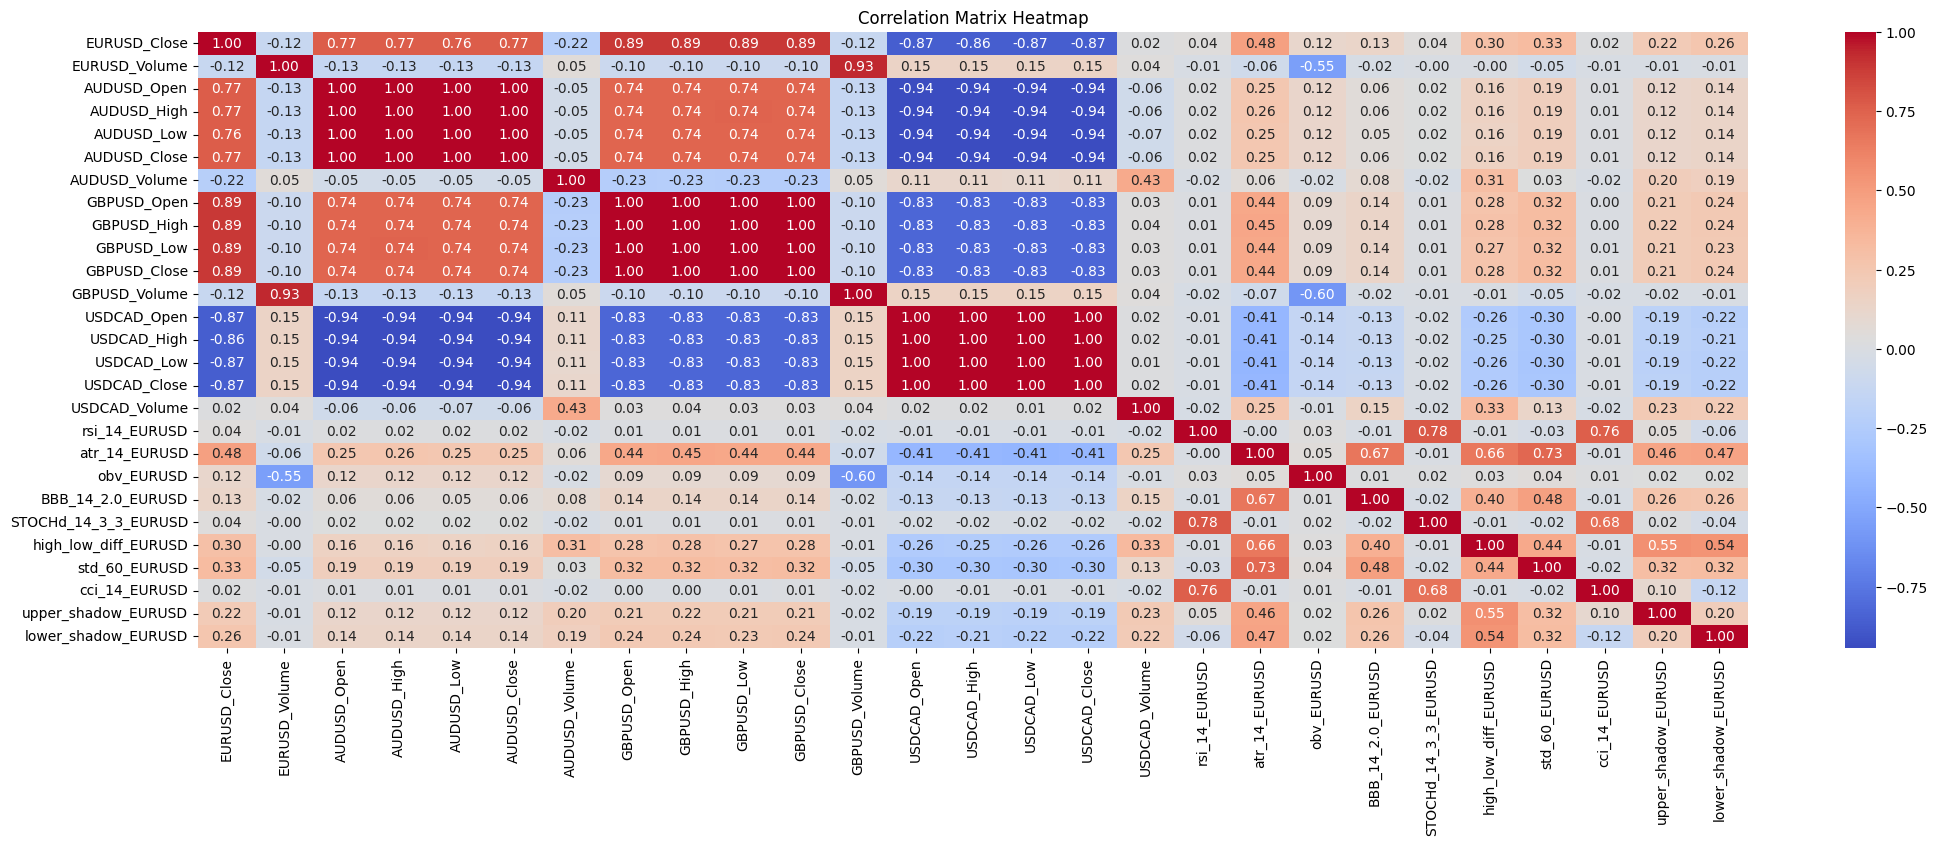

In [10]:
import seaborn as sns
correlation_matrix = df[[ 'EURUSD_Close',
       'EURUSD_Volume', 'AUDUSD_Open', 'AUDUSD_High', 'AUDUSD_Low',
       'AUDUSD_Close', 'AUDUSD_Volume', 'GBPUSD_Open', 'GBPUSD_High',
       'GBPUSD_Low', 'GBPUSD_Close', 'GBPUSD_Volume', 'USDCAD_Open',
       'USDCAD_High', 'USDCAD_Low', 'USDCAD_Close', 'USDCAD_Volume',
       'rsi_14_EURUSD', 'atr_14_EURUSD', 'obv_EURUSD', 'BBB_14_2.0_EURUSD',
       'STOCHd_14_3_3_EURUSD',
       'high_low_diff_EURUSD', 'std_60_EURUSD', 'cci_14_EURUSD',
       'upper_shadow_EURUSD', 'lower_shadow_EURUSD']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [11]:
input_features = [ 'EURUSD_Close',
       'EURUSD_Volume', 'AUDUSD_Open', 'AUDUSD_High', 'AUDUSD_Low',
       'AUDUSD_Close', 'AUDUSD_Volume', 'GBPUSD_Open', 'GBPUSD_High',
       'GBPUSD_Low', 'GBPUSD_Close', 'GBPUSD_Volume', 'USDCAD_Open',
       'USDCAD_High', 'USDCAD_Low', 'USDCAD_Close', 'USDCAD_Volume',
       'rsi_14_EURUSD', 'atr_14_EURUSD', 'obv_EURUSD', 'BBB_14_2.0_EURUSD',
       'STOCHd_14_3_3_EURUSD',
       'high_low_diff_EURUSD', 'std_60_EURUSD', 'cci_14_EURUSD',
       'upper_shadow_EURUSD', 'lower_shadow_EURUSD']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['EURUSD_Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [12]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 128
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [13]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84244
تعداد نمونه‌های Validation: 10530
تعداد نمونه‌های Test: 10532


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# تعریف Time2Vector
class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__(**kwargs)
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                             shape=(self.seq_len,),
                                             initializer='uniform',
                                             trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(self.seq_len,),
                                           initializer='uniform',
                                           trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(self.seq_len,),
                                                initializer='uniform',
                                                trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(self.seq_len,),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x, axis=-1)  # میانگین روی همه فیچرها
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        return tf.concat([time_linear, time_periodic], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], 2)

# تابع ترنسفورمر انکودر
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    return x + res

# تعریف مدل
input_layer = Input(shape=(128, len(input_features)))
time_embedding = Time2Vector(seq_len=128)(input_layer)
concatenated = Concatenate()([input_layer, time_embedding])

x = transformer_encoder(concatenated, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1)(x)  # بدون activation برای پیش‌بینی پیوسته

model = Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 27)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector              │ (None, 128, 2)         │            512 │ input_layer[0][0]      │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 29)        │              0 │ input_layer[0][0],     │
│                           │                        │                │ time2_vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 29)        │             58 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 29)        │          1,457 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 29)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 29)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 29)        │             58 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 128)       │          3,840 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 29)        │          3,741 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 29)        │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 29)        │             58 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 29)        │          1,457 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 29)        │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 29,959 (117.03 KB)

 Trainable params: 29,959 (117.03 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 0.0655 - mae: 0.1507 - val_loss: 0.0051 - val_mae: 0.0658
Epoch 2/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0051 - mae: 0.0535 - val_loss: 0.0170 - val_mae: 0.1256
Epoch 3/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0032 - mae: 0.0421 - val_loss: 0.0066 - val_mae: 0.0757
Epoch 4/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0023 - mae: 0.0352 - val_loss: 0.0023 - val_mae: 0.0456
Epoch 5/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0016 - mae: 0.0298 - val_loss: 3.7110e-04 - val_mae: 0.0158
Epoch 6/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0013 - mae: 0.0262 - val_loss: 4.3226e-04 - val_mae: 0.0159
Epoch 7/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 3.6015e-04 - val_mae: 0.0142
Epoch 8/100
2633/2633 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 9.4081e-04 - mae: 0.0223 - val_loss: 5.9047e-04 - val_mae: 0.0177
Epo

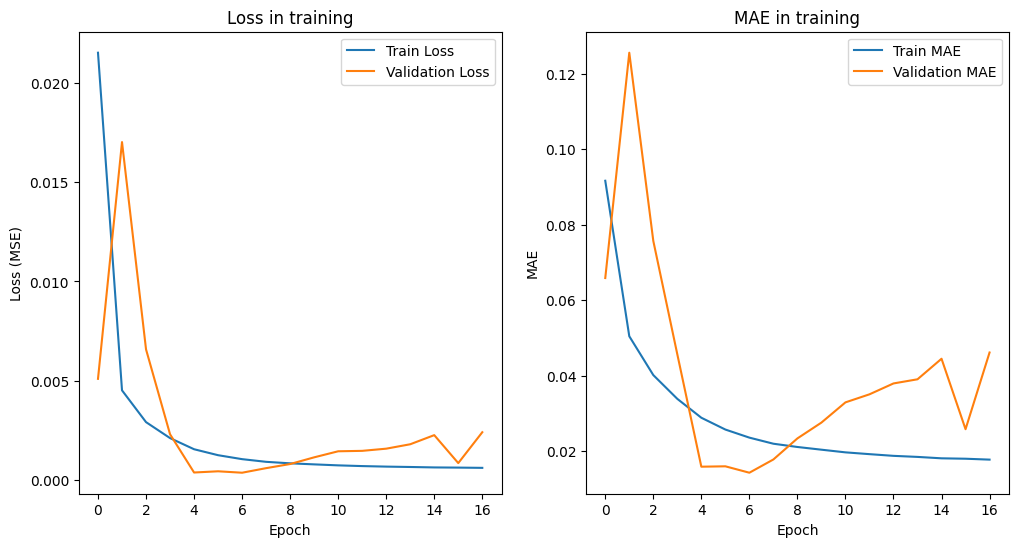

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

معیارهای ارزیابی برای EURUSD_Close:
MSE: 8.146682093275835e-05
RMSE: 0.009025897236993026
MAE: 0.00737370266404027
R² Score: 0.7113646772974923


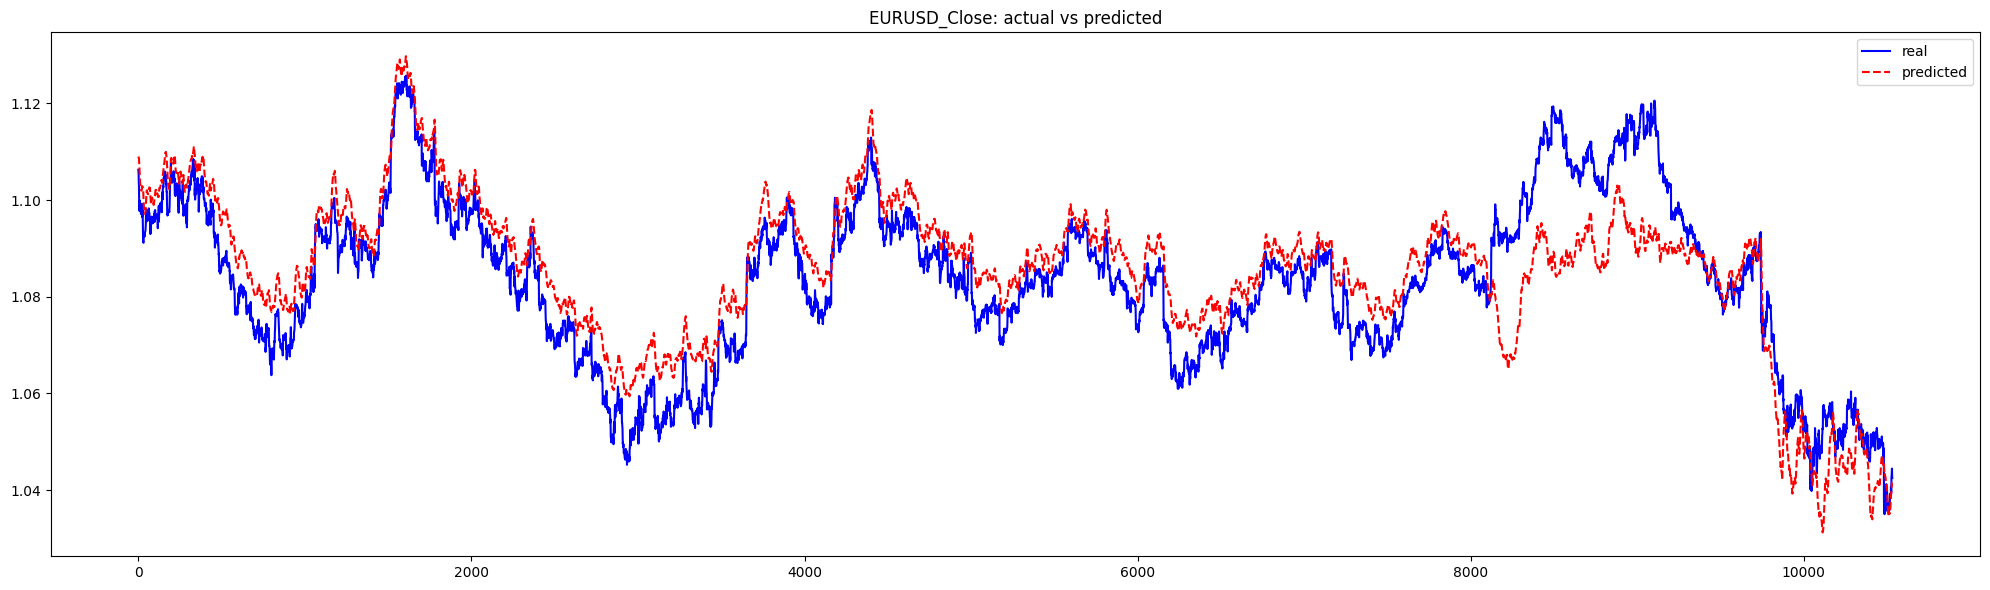

In [18]:
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_average = scalers_outputs['EURUSD_Close'].inverse_transform(predictions[:, 0].reshape(-1, 1))


y_test_average = scalers_outputs['EURUSD_Close'].inverse_transform(y_test[:, 0].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_average, predictions_average, "EURUSD_Close")



# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)
plt.plot(y_test_average, label='real', color='blue')
plt.plot(predictions_average, label='predicted', color='red',linestyle='--')
plt.title('EURUSD_Close: actual vs predicted')
plt.legend()



plt.tight_layout()
plt.show()

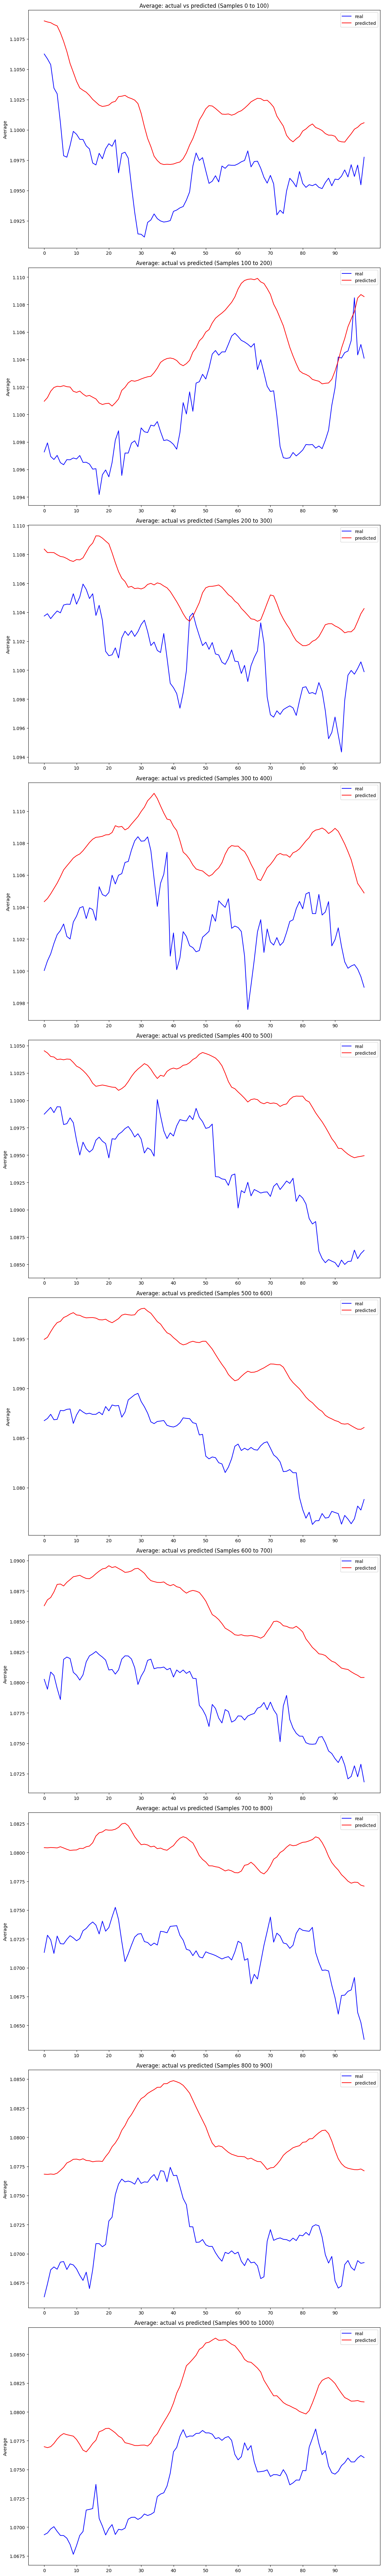

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# فرض می‌کنیم y_test_average و predictions_average آرایه‌های شما هستن
# y_test_average: مقادیر واقعی Average برای داده‌های تست
# predictions_average: مقادیر پیش‌بینی‌شده Average توسط مدل

# تعداد نمونه‌هایی که می‌خوای رسم کنی (1000 نمونه اول)
total_samples = 1000
n_samples_per_plot = 100  # تعداد نمونه‌ها در هر نمودار
n_plots = total_samples // n_samples_per_plot  # تعداد نمودارها (10)

# تنظیمات شکل کلی
plt.figure(figsize=(12, 8 * n_plots))  # ارتفاع شکل رو متناسب با تعداد نمودارها تنظیم می‌کنیم

# حلقه برای رسم 10 نمودار
for i in range(n_plots):
    # محاسبه بازه نمونه‌ها برای هر نمودار
    start_idx = i * n_samples_per_plot
    end_idx = (i + 1) * n_samples_per_plot
    
    # انتخاب داده‌ها برای این بازه
    y_test_subset = y_test_average[start_idx:end_idx]
    predictions_subset = predictions_average[start_idx:end_idx]
    
    # ایجاد زیرنمودار
    plt.subplot(n_plots, 1, i + 1)  # n_plots ردیف، 1 ستون، اندیس i+1
    
    # رسم خطوط
    plt.plot(y_test_subset, label='real', color='blue')
    plt.plot(predictions_subset, label='predicted', color='red')
    
    # اضافه کردن عنوان و لیبل‌ها
    plt.title(f'Average: actual vs predicted (Samples {start_idx} to {end_idx})')
    plt.ylabel('Average')
    plt.legend()
    
    # تنظیم محور x برای نمایش اندیس نمونه‌ها
    plt.xticks(np.arange(0, n_samples_per_plot, 10))  # تیک‌ها هر 10 نمونه

# تنظیمات نهایی و نمایش نمودار
plt.tight_layout()
plt.show()

MAE on Test Data (First 100 Samples): 0.0048583244701385486
RMSE on Test Data (First 100 Samples): 0.005150888298566115


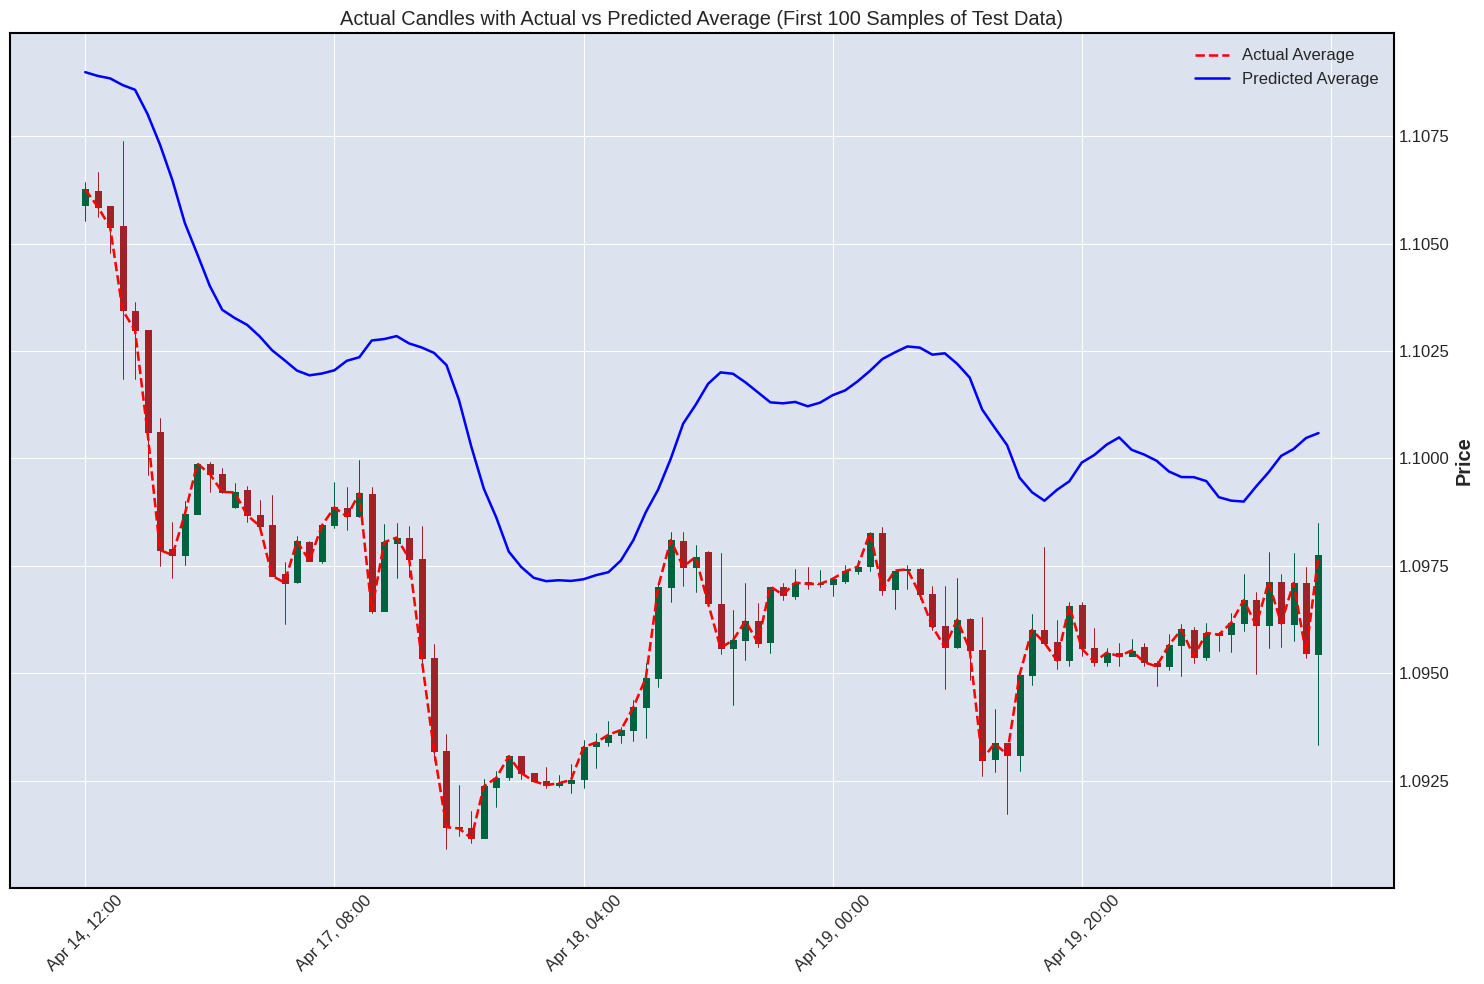

In [24]:
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# فرض می‌کنیم data دیتافریم اولیه شماست که ستون‌های EURUSD_Open, EURUSD_High, EURUSD_Low, EURUSD_Close, EURUSD_Average داره
n_test_samples = len(X_test)  # تعداد نمونه‌های تست: 21186

# انتخاب داده‌های تست از دیتافریم data
test_data = df.iloc[-n_test_samples:].copy()
test_data.index = pd.DatetimeIndex(test_data.index)  # اطمینان از اینکه ایندکس به فرمت DatetimeIndex باشه

# محدود کردن تعداد نمونه‌ها برای رسم (100 نمونه اول)
n_samples_to_plot = 100
test_data = test_data.iloc[:n_samples_to_plot]  # 100 نمونه اول

# تغییر نام ستون‌ها به فرمت استاندارد برای mplfinance
test_data_renamed = test_data.rename(columns={
    'EURUSD_Open': 'Open',
    'EURUSD_High': 'High',
    'EURUSD_Low': 'Low',
    'EURUSD_Close': 'Close'
})

# فرض می‌کنیم predictions خروجی مدل شماست و برای داده‌های تست (X_test) هست
predicted_average = predictions.flatten()  # تبدیل به آرایه یک‌بعدی
predicted_average = predicted_average[:n_samples_to_plot]  # محدود کردن به 100 نمونه اول

# اگه predictions نرمال‌سازی‌شده هست، به مقیاس اصلی برمی‌گردونیم
predicted_average = scalers_outputs['EURUSD_Close'].inverse_transform(predicted_average.reshape(-1, 1)).flatten()

# ایجاد یک DataFrame برای Average پیش‌بینی‌شده با همان ایندکس
predicted_df = pd.DataFrame({
    'Predicted_Average': predicted_average
}, index=test_data.index)

# برای مقایسه، Average واقعی رو از test_data می‌گیریم
actual_average = test_data['EURUSD_Close'].values
actual_average_df = pd.DataFrame({
    'Actual_Average': actual_average
}, index=test_data.index)

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(actual_average, predicted_average)
rmse = np.sqrt(mean_squared_error(actual_average, predicted_average))
print(f"MAE on Test Data (First 100 Samples): {mae}")
print(f"RMSE on Test Data (First 100 Samples): {rmse}")

# تنظیمات برای رسم
fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

# رسم کندل‌استیک‌ها با دیتافریم تغییر نام داده‌شده
mpf.plot(test_data_renamed, type='candle', style='charles', ax=ax, volume=False)

# اضافه کردن خط Actual Average
ap1 = mpf.make_addplot(actual_average_df['Actual_Average'], type='line', color='red', linestyle='--', ax=ax, label='Actual Average')

# اضافه کردن خط Predicted Average
ap2 = mpf.make_addplot(predicted_df['Predicted_Average'], type='line', color='blue', linestyle='-', ax=ax, label='Predicted Average')

# رسم کندل‌ها با هر دو خط
mpf.plot(test_data_renamed, type='candle', style='charles', ax=ax, volume=False, addplot=[ap1, ap2])

# اضافه کردن عنوان و لیبل‌ها
ax.set_title('Actual Candles with Actual vs Predicted Average (First 100 Samples of Test Data)')
ax.set_ylabel('Price')

# نمایش لجند
ax.legend()

# تنظیمات نهایی و نمایش نمودار
fig.tight_layout()
mpf.show()